## Use ENGIE’s open data set

ENGIE provides access to the data of its 'La Haute Borne' wind farm through https://opendata-renewables.engie.com and through an API. The data can be used to create additional turbine objects and gives users the opportunity to work with further real-world data. 

The series of notebooks in the 'examples' folder uses SCADA data downloaded from https://opendata-renewables.engie.com, saved in the 'examples/data' folder. Additional plant level meter, availability, and curtailment data were synthesized based on the SCADA data.

In the following example, data is loaded into a turbine object and plotted as a power curve. The selected turbine can be changed if desired.

In [ ]:
%pip install pyproj shapely pygam koalas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import databricks.koalas as pd # replaces: 'import pandas as pd'

import sys
sys.path.insert(1, '/home/jovyan/OpenOA/')

from project_ENGIE import Project_Engie
from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve

### Import the data

In [2]:
project = Project_Engie('./data/la_haute_borne')
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


In [3]:
# List of turbines
turb_list = project.scada.df.id.unique()
turb_list

array(['R80736', 'R80721', 'R80790', 'R80711'], dtype=object)

Let's examine the first turbine from the list above.

In [4]:
df = project.scada.df.loc[project.scada.df['id'] == turb_list[0]]
windspeed = df["wmet_wdspd_avg"]
power_kw = df["wtur_W_avg"]/1000 # Put into kW


In [5]:
def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 1, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 1, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (W)')
    plt.show()

First, we'll make a scatter plot the raw power curve data.

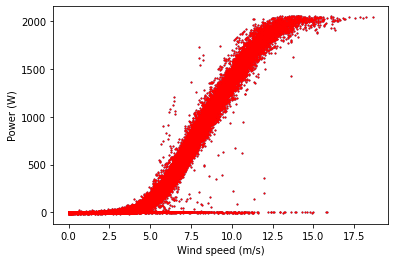

In [6]:
plot_flagged_pc(windspeed, power_kw, np.repeat(True, df.shape[0]), 1)

### Range filter

In [7]:
out_of_range = filters.range_flag(windspeed, below=0, above=70)
windspeed[out_of_range].head()

Series([], Name: wmet_wdspd_avg, dtype: float64)

No wind speeds out of range

### Window range filter

Now, we'll apply a window range filter to remove data with power values outside of the window from 20 to 2100 kW for wind speeds between 5 and 40 m/s.

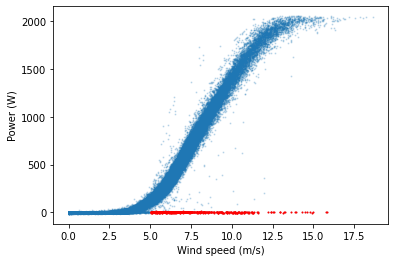

In [8]:
out_of_window = filters.window_range_flag(windspeed, 5., 40, power_kw, 20., 2100.)
plot_flagged_pc(windspeed, power_kw, out_of_window, 0.2)

Let's remove these flagged data from consideration

In [9]:
windspeed_filt1 = windspeed[~out_of_window]
power_kw_filt1 = power_kw[~out_of_window]

### Bin filter

We may be interested in fitting a power curve to data representing 'normal' turbine operation. In other words, we want to flag all anomalous data or data represenatative of underperformance. To do this, the 'bin_filter' function is useful. It works by binning the data by a specified variable, bin width, and start and end points. The criteria for flagging is based on some measure (scalar or standard deviation) from the mean or median of the bin center. 

As an example, let's bin on power in 100 kW increments, starting from 25.0 kW but stopping at 90% of peak power (i.e. we don't want to flag all the data at peak power and high wind speed. Let's use a scalar threshold of 1.5 m/s from the median for each bin. Let's also consider data on both sides of the curve by setting the 'direction' parameter to 'all'

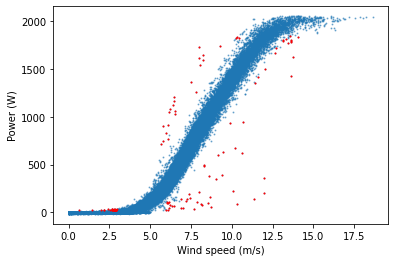

In [10]:
max_bin = 0.90*power_kw_filt1.max()
bin_outliers = filters.bin_filter(power_kw_filt1, windspeed_filt1, 100, 1.5, 'median', 20., max_bin, 'scalar', 'all')
plot_flagged_pc(windspeed_filt1, power_kw_filt1, bin_outliers, 0.5)

As seen above, one call for the bin filter has done a decent job of cleaning up the power curve to represent 'normal' operation, without excessive removal of data points. There are a few points at peak power but low wind speed that weren't flagged, however. Let catch those, and then remove those as well as the flagged data above, and plot our 'clean' power curve 

In [11]:
windspeed_filt2 = windspeed_filt1[~bin_outliers]
power_kw_filt2 = power_kw_filt1[~bin_outliers]

#### Unresponsive Filter

As a final filtering demonstration, we can look for an unrespsonsive sensor (i.e. repeating measurements). In this case, let's look for 3 or more repeating wind speed measurements:

In [12]:
frozen = filters.unresponsive_flag(windspeed_filt2, 3)
windspeed_filt2[frozen]

time
2014-01-10 14:40:00    0.0
2014-01-10 14:50:00    0.0
2014-01-10 15:00:00    0.0
2014-01-11 22:30:00    0.0
2014-01-11 22:40:00    0.0
                      ... 
2015-12-09 22:50:00    0.0
2015-12-09 23:00:00    0.0
2015-12-15 02:20:00    5.5
2015-12-15 02:30:00    5.5
2015-12-15 02:40:00    5.5
Name: wmet_wdspd_avg, Length: 1926, dtype: float64

We actually found a lot, so let's remove these data as well before moving on to power curve fitting.

Note that many of the unresponsive sensor values identified above are likely caused by the discretization of the data to only two decimal places. However, the goal is to illustrate the filtering process.

In [13]:
windspeed_final = windspeed_filt2[~frozen]
power_kw_final = power_kw_filt2[~frozen]

##### Power curve fitting

We will now consider three different models for fitting a power curve to the SCADA data.

In [14]:
# Fit the power curves
iec_curve = power_curve.IEC(windspeed_final, power_kw_final)
l5p_curve = power_curve.logistic_5_parametric(windspeed_final, power_kw_final)
spline_curve = power_curve.gam(windspeed_final, power_kw_final, n_splines = 20)

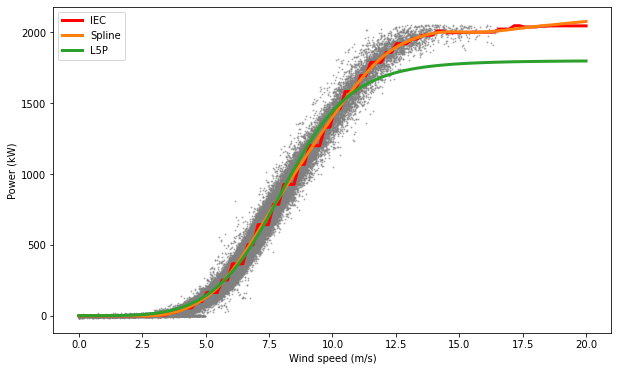

In [15]:
# Plot the results
x = np.linspace(0,20,100)
plt.figure(figsize = (10,6))
plt.scatter(windspeed_final, power_kw_final, alpha=0.5, s = 1, c = 'gray')
plt.plot(x, iec_curve(x), color="red", label = 'IEC', linewidth = 3)
plt.plot(x, spline_curve(x), color="C1", label = 'Spline', linewidth = 3)
plt.plot(x, l5p_curve(x), color="C2", label = 'L5P', linewidth = 3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

The above plot shows that the IEC method accurately captures the power curve, although it results in a 'choppy' fit, while the L5P model (constrained by its parametric form) deviates from the knee of the power curve through peak production. The spline fit tends to fit the best.